Found baseline (no noise) for TREX: reward=66.75
Found baseline (no noise) for CLASSIFIER_BC: reward=83.5999984741211
Found baseline (no noise) for IQL: reward=36.099998474121094
Found baseline (no noise) for GAIL: reward=82.75


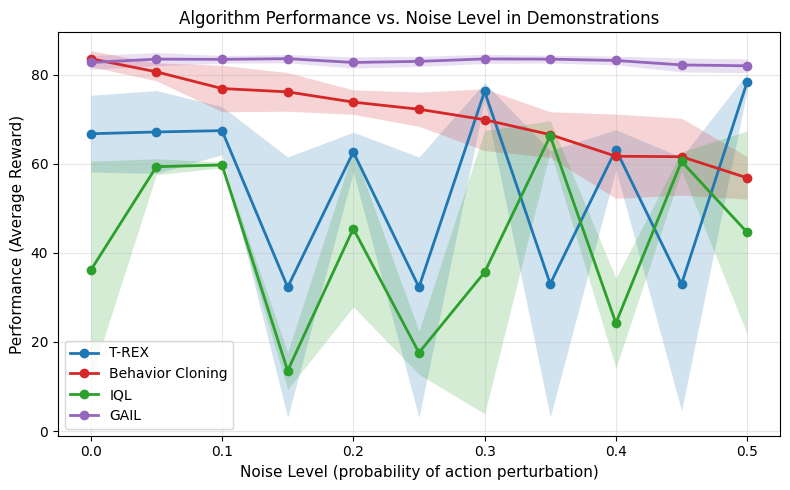


Performance Summary:

T-REX:
  Noise 0.00: 66.75 ± 8.62
  Noise 0.05: 67.15 ± 9.30
  Noise 0.10: 67.45 ± 5.40
  Noise 0.15: 32.30 ± 29.22
  Noise 0.20: 62.65 ± 4.44
  Noise 0.25: 32.30 ± 29.22
  Noise 0.30: 76.25 ± 1.95
  Noise 0.35: 33.05 ± 29.90
  Noise 0.40: 63.20 ± 4.47
  Noise 0.45: 33.00 ± 28.46
  Noise 0.50: 78.40 ± 1.91

Behavior Cloning:
  Noise 0.00: 83.60 ± 1.80
  Noise 0.05: 80.65 ± 2.01
  Noise 0.10: 76.90 ± 5.21
  Noise 0.15: 76.15 ± 4.34
  Noise 0.20: 73.85 ± 2.74
  Noise 0.25: 72.25 ± 3.85
  Noise 0.30: 69.90 ± 6.93
  Noise 0.35: 66.55 ± 5.13
  Noise 0.40: 61.70 ± 9.45
  Noise 0.45: 61.60 ± 8.64
  Noise 0.50: 56.85 ± 4.78

IQL:
  Noise 0.00: 36.10 ± 24.50
  Noise 0.05: 59.35 ± 1.80
  Noise 0.10: 59.75 ± 0.62
  Noise 0.15: 13.55 ± 4.15
  Noise 0.20: 45.45 ± 17.58
  Noise 0.25: 17.60 ± 4.85
  Noise 0.30: 35.65 ± 31.77
  Noise 0.35: 66.25 ± 3.42
  Noise 0.40: 24.25 ± 10.09
  Noise 0.45: 60.55 ± 2.11
  Noise 0.50: 44.60 ± 22.80

GAIL:
  Noise 0.00: 82.75 ± 1.55
  Noise 0.0

In [3]:
import json
import re
import matplotlib.pyplot as plt
import numpy as np

INDEX_PATH = "../../comparison_outputs/index_breakout_noisy.json"

# Load index
with open(INDEX_PATH, "r") as f:
    index = json.load(f)
 
# Known algos we want to plot (add more as needed)
ALGOS = ["TREX", "CLASSIFIER_BC", "IQL", "GAIL"]

# Storage
storages = {algo: {"noise_level": [], "mean": [], "std": []} for algo in ALGOS}

# Regex to extract noise level from filenames like "noise_data_noise0.1.npz"
noise_regex = re.compile(r"noise_data_noise([\d.]+)\.npz$")

for entry in index:
    algo = entry["algo"]            # e.g. "TREX", "CLASSIFIER_BC", "IQL", "GAIL"
    fname = entry["dataset_name"]   # e.g. "noise_data_noise0.1.npz" or "noise_data.npz"
    reward = entry["avg_reward"]
    std_reward = entry.get("std_reward")

    # Check if this is the expert/baseline (no noise - "noise_data.npz")
    if fname == "noise_data.npz":
        # Treat this as noise level 0.0
        noise_level = 0.0
        print(f"Found baseline (no noise) for {algo}: reward={reward}")
    else:
        # Try to extract noise level from filename
        match = noise_regex.match(fname)
        if match is None:
            print(f"Skipping unrecognized filename: {fname}")
            continue
        # Extract noise level as float
        noise_level = float(match.group(1))

    if algo in storages:
        storages[algo]["noise_level"].append(noise_level)
        storages[algo]["mean"].append(reward)
        storages[algo]["std"].append(std_reward if std_reward is not None else 0.0)

# Convert to sorted curves (by noise level)
for algo, data in storages.items():
    sorted_pairs = sorted(zip(data["noise_level"], data["mean"], data["std"]))
    if sorted_pairs:
        n, m, st = zip(*sorted_pairs)
        storages[algo] = {
            "noise_level": np.array(n),
            "mean": np.array(m),
            "std": np.array(st),
        }
    else:
        storages[algo] = {"noise_level": np.array([]), "mean": np.array([]), "std": np.array([])}

# --- Plot ---
plt.figure(figsize=(8, 5))
colors = {
    "TREX": "#1f77b4",          # blue
    "CLASSIFIER_BC": "#d62728", # red
    "IQL": "#2ca02c",           # green
    "GAIL": "#9467bd",          # purple
}
labels = {
    "TREX": "T-REX",
    "CLASSIFIER_BC": "Behavior Cloning",
    "IQL": "IQL",
    "GAIL": "GAIL",
}

for algo, data in storages.items():
    if data["noise_level"].size == 0:
        continue
    c = colors.get(algo, None)
    plt.plot(data["noise_level"], data["mean"], marker="o", label=labels.get(algo, algo), color=c, linewidth=2)
    plt.fill_between(
        data["noise_level"],
        data["mean"] - data["std"],
        data["mean"] + data["std"],
        color=c,
        alpha=0.2,
        linewidth=0,
    )

plt.xlabel("Noise Level (probability of action perturbation)", fontsize=11)
plt.ylabel("Performance (Average Reward)", fontsize=11)
plt.title("Algorithm Performance vs. Noise Level in Demonstrations", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPerformance Summary:")
for algo, data in storages.items():
    if data["noise_level"].size > 0:
        print(f"\n{labels.get(algo, algo)}:")
        for i, noise in enumerate(data["noise_level"]):
            print(f"  Noise {noise:.2f}: {data['mean'][i]:.2f} ± {data['std'][i]:.2f}")
